In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from datetime import datetime

In [2]:
forest_data = pd.ExcelFile('Bird_Monitoring_Data_FOREST.XLSX')
grassland_data = pd.ExcelFile('Bird_Monitoring_Data_GRASSLAND.XLSX')

forest_sheets = forest_data.sheet_names
grassland_sheets = grassland_data.sheet_names
warnings.simplefilter('ignore')

In [3]:
# Data Parsing
forest_dict = {sheet: forest_data.parse(sheet) for sheet in forest_sheets}
grassland_dict = {sheet: grassland_data.parse(sheet) for sheet in grassland_sheets}

In [4]:
df1 = pd.concat(
    [df.assign(sheet = sheet_name) for sheet_name, df in forest_dict.items()]
)

df2 = pd.concat(
    [df.assign(sheet = sheet_name) for sheet_name, df in grassland_dict.items()]
)
'''
8546 rows x 30 columns
'''

'\n8546 rows x 30 columns\n'

In [5]:
combined_df = pd.concat([df1,df2], ignore_index=True)

In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17077 entries, 0 to 17076
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Admin_Unit_Code              17077 non-null  object        
 1   Sub_Unit_Code                722 non-null    object        
 2   Site_Name                    8546 non-null   object        
 3   Plot_Name                    17077 non-null  object        
 4   Location_Type                17077 non-null  object        
 5   Year                         17077 non-null  object        
 6   Date                         17077 non-null  datetime64[ns]
 7   Start_Time                   17077 non-null  object        
 8   End_Time                     17077 non-null  object        
 9   Observer                     17077 non-null  object        
 10  Visit                        17077 non-null  object        
 11  Interval_Length              17077 non-nu

In [7]:
combined_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,17077,2018-06-13 11:42:14.988581120,2018-05-07 00:00:00,2018-05-24 00:00:00,2018-06-14 00:00:00,2018-07-04 00:00:00,2018-07-19 00:00:00,NaN
AcceptedTSN,17044.0,222753.084722,174717.0,178581.0,179124.0,179637.0,950106.0,147357.504754
NPSTaxonCode,8546.0,137088.791013,76625.0,85846.0,88350.0,94215.0,926917.0,154932.276585
Temperature,17077.0,22.570399,11.0,19.700001,22.299999,25.200001,37.299999,4.263851
Humidity,17077.0,73.692112,7.3,67.5,75.800003,83.0,98.800003,12.32838
TaxonCode,8529.0,103234.178567,76625.0,85643.0,88038.0,94206.0,926917.0,83967.631378


In [8]:
# NaN summary

missing_count = combined_df.isnull().sum()
missing_percentage = (missing_count / len(combined_df)) *100

In [9]:
summary = pd.concat([missing_count,missing_percentage], axis=1, keys=['Count','Percent'])
print(summary[summary['Count'] > 0].sort_values('Count', ascending=False))

combined_df.duplicated()

                Count    Percent
Sub_Unit_Code   16355  95.772091
TaxonCode        8548  50.055630
Previously_Obs   8546  50.043919
Site_Name        8531  49.956081
NPSTaxonCode     8531  49.956081
Sex              5183  30.350764
Distance         1486   8.701763
AcceptedTSN        33   0.193242
ID_Method           2   0.011712


0        False
1        False
2        False
3        False
4        False
         ...  
17072     True
17073     True
17074     True
17075     True
17076     True
Length: 17077, dtype: bool

In [10]:
duplicates = combined_df.duplicated().sum()
print(f'The No.of Duplicates observed in the data is {duplicates}')

The No.of Duplicates observed in the data is 1705


In [11]:
# Dropping Duplicates
combined_df = combined_df.drop_duplicates(keep=False)

In [12]:
# Dropping un-wanted Columns
combined_df = combined_df.drop(columns=['Sub_Unit_Code','TaxonCode','Previously_Obs','Site_Name','NPSTaxonCode','Sex','sheet'])

In [13]:
# Processed data copy
df = combined_df.copy()

In [14]:
df.to_excel("Bird_observatory_data2.xlsx")

In [15]:
'''
Analyze the distribution of species across administrative units and habitat types.
'''
species_distribution = df.groupby(['Admin_Unit_Code','Location_Type'])['Common_Name'].nunique().reset_index(name= 'Species_Count')
species_distribution

,Admin_Unit_Code,Location_Type,Species_Count
0,ANTI,Forest,46
1,ANTI,Grassland,78
2,CATO,Forest,46
3,CHOH,Forest,80
4,GWMP,Forest,49
5,HAFE,Forest,47
6,HAFE,Grassland,32
7,MANA,Forest,57
8,MANA,Grassland,73
9,MONO,Forest,55


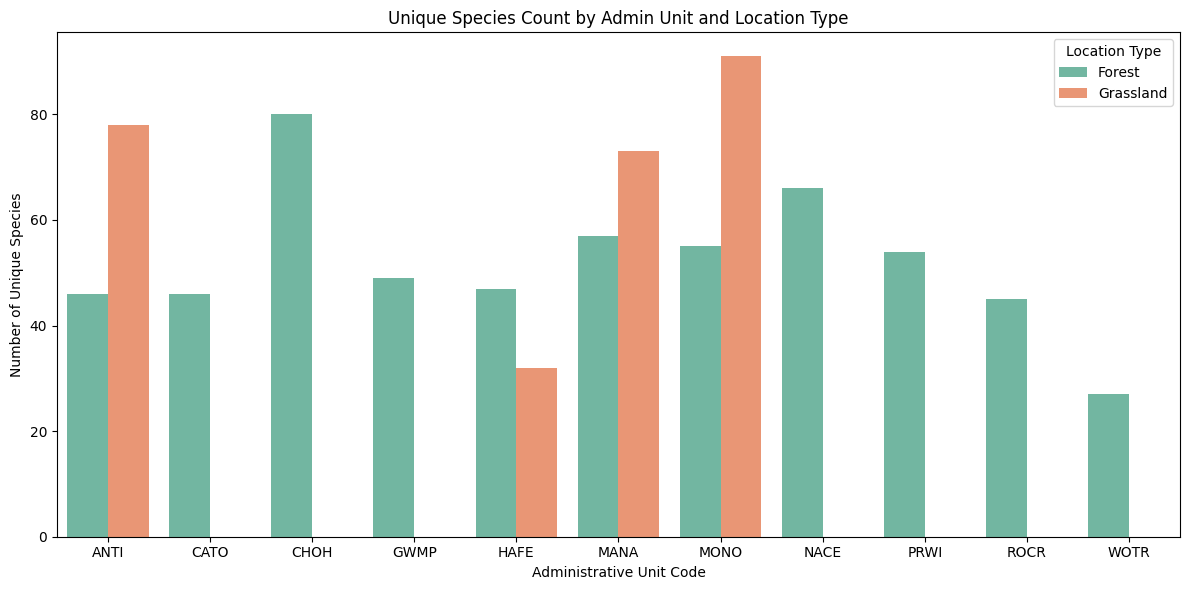

In [16]:
'''
# Plotting
# Distribution between Environmental Condition & Bird Activity

'''
plt.figure(figsize = (12,6))
sns.barplot(data = species_distribution,
            x = 'Admin_Unit_Code',
            y = 'Species_Count',
            hue = 'Location_Type',
            palette = 'Set2')
plt.title('Unique Species Count by Admin Unit and Location Type')
plt.xlabel('Administrative Unit Code')
plt.ylabel('Number of Unique Species')
plt.legend(title='Location Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

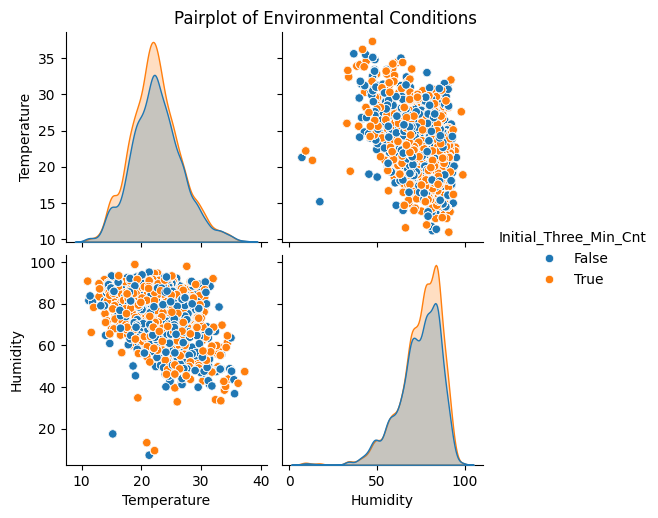

In [17]:
'''
Investigate relationships between environmental conditions 
(e.g., temperature, humidity) and bird activity.

'''

sns.pairplot(df, hue='Initial_Three_Min_Cnt', vars=['Temperature', 'Humidity'])
plt.suptitle("Pairplot of Environmental Conditions", y=1.02)
plt.show()

In [18]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year

# Activity Grouping

daily_activity = df.groupby('Date')['Initial_Three_Min_Cnt'].sum().reset_index()
yearly_activity = df.groupby('Year')['Initial_Three_Min_Cnt'].sum().reset_index()



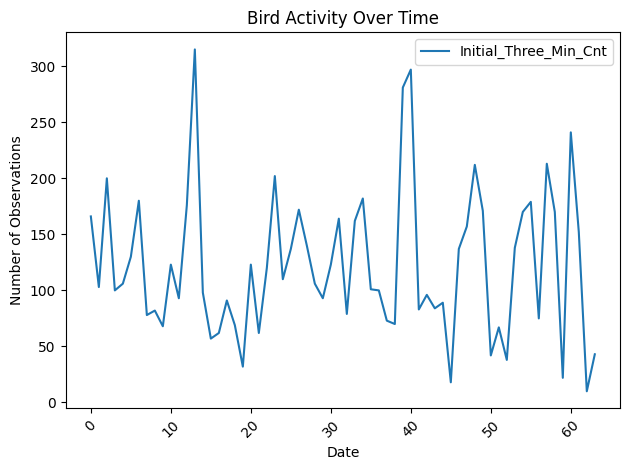

In [19]:
sns.lineplot(data=daily_activity)
plt.title('Bird Activity Over Time')
plt.ylabel('Number of Observations')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
'''
Using Pivot method to identify how many unique birds
that live in forest and grassland

'''
# obs_pattern = df.melt(id_vars = 'Location_Type', var_name = 'Common_Name', value_name = 'Count')
loc_pattern = df.groupby(['Location_Type','Common_Name']).size().unstack(fill_value=0).reset_index()


In [21]:
loc_pattern

Common_Name,Location_Type,Acadian Flycatcher,American Crow,American Goldfinch,American Kestrel,American Redstart,American Robin,Bald Eagle,Baltimore Oriole,Barn Swallow,...,Willow Flycatcher,Wood Duck,Wood Thrush,Worm-eating Warbler,Yellow Warbler,Yellow-billed Cuckoo,Yellow-breasted Chat,Yellow-rumped Warbler,Yellow-throated Vireo,Yellow-throated Warbler
0,Forest,436,142,147,0,25,294,0,20,2,...,0,3,290,31,13,133,4,3,55,3
1,Grassland,26,120,265,6,7,161,5,37,78,...,2,1,19,0,6,43,5,0,3,0


In [22]:
obs_pattern = loc_pattern.melt(id_vars = 'Location_Type', var_name = 'Common_Name', value_name = 'Count')
obs_pattern

,Location_Type,Common_Name,Count
0,Forest,Acadian Flycatcher,436
1,Grassland,Acadian Flycatcher,26
2,Forest,American Crow,142
3,Grassland,American Crow,120
4,Forest,American Goldfinch,147
...,...,...,...
245,Grassland,Yellow-rumped Warbler,0
246,Forest,Yellow-throated Vireo,55
247,Grassland,Yellow-throated Vireo,3
248,Forest,Yellow-throated Warbler,3


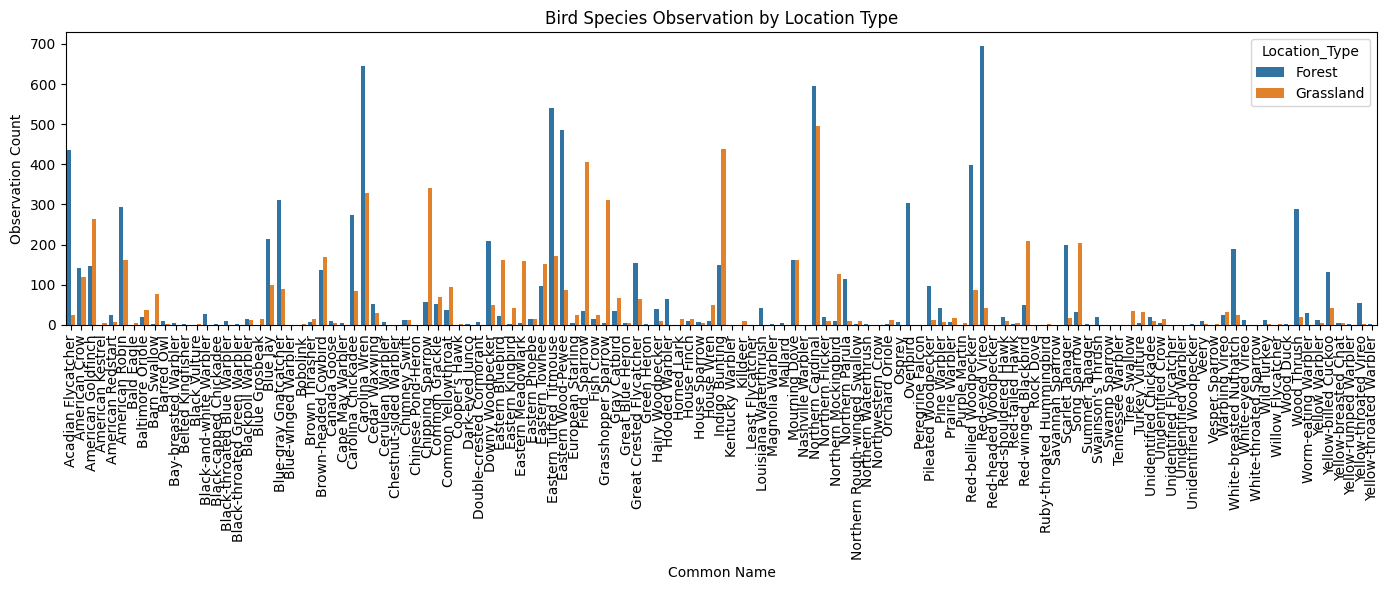

In [23]:
plt.figure(figsize=(14, 6))
sns.barplot(data=obs_pattern, x='Common_Name', y='Count', hue='Location_Type')

plt.xticks(rotation=90)
plt.title('Bird Species Observation by Location Type')
plt.xlabel('Common Name')
plt.ylabel('Observation Count')
plt.tight_layout()
plt.show()

In [24]:
top_species = obs_pattern.groupby('Common_Name')['Count'].sum().nlargest(15).index
obs_pattern_filtered = obs_pattern[obs_pattern['Common_Name'].isin(top_species)]

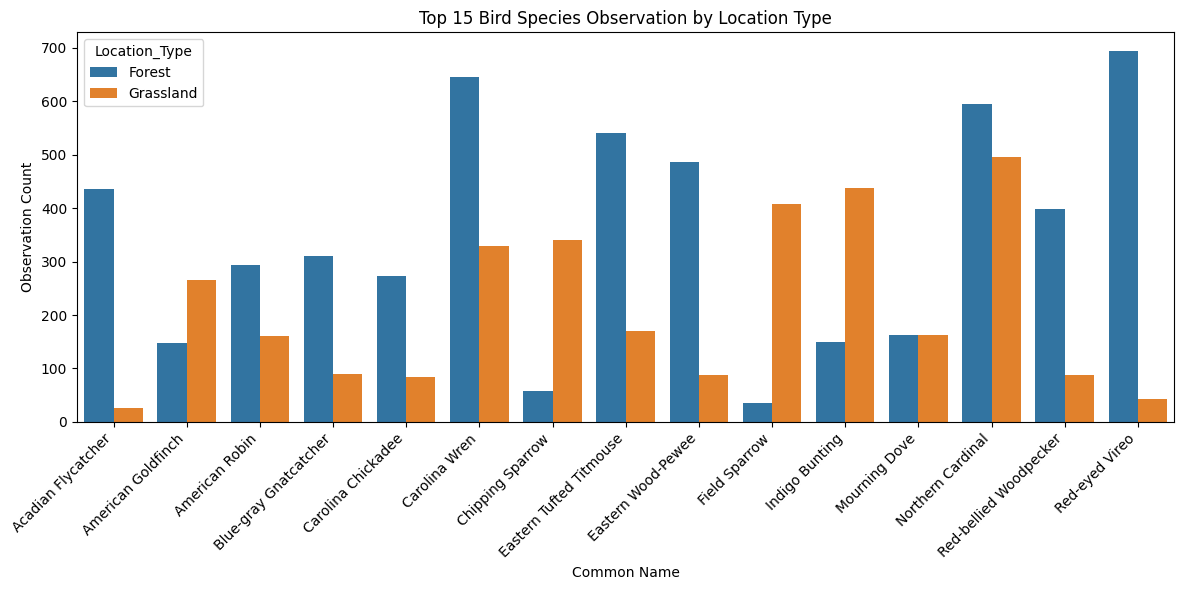

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(data=obs_pattern_filtered, x='Common_Name', y='Count', hue='Location_Type')
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Bird Species Observation by Location Type')
plt.xlabel('Common Name')
plt.ylabel('Observation Count')
plt.tight_layout()
plt.show()

In [25]:
df['Start_Time_mod'] = pd.to_datetime(df['Start_Time'], format='%H:%M:%S').dt.time

In [26]:
time_activity = df.groupby('Start_Time')['Initial_Three_Min_Cnt'].count().reset_index()

In [27]:
time_activity

,Start_Time,Initial_Three_Min_Cnt
0,05:18:00,13
1,05:25:00,13
2,05:26:00,12
3,05:29:00,24
4,05:30:00,9
...,...,...
313,10:44:00,6
314,10:45:00,21
315,10:47:00,10
316,10:48:00,9


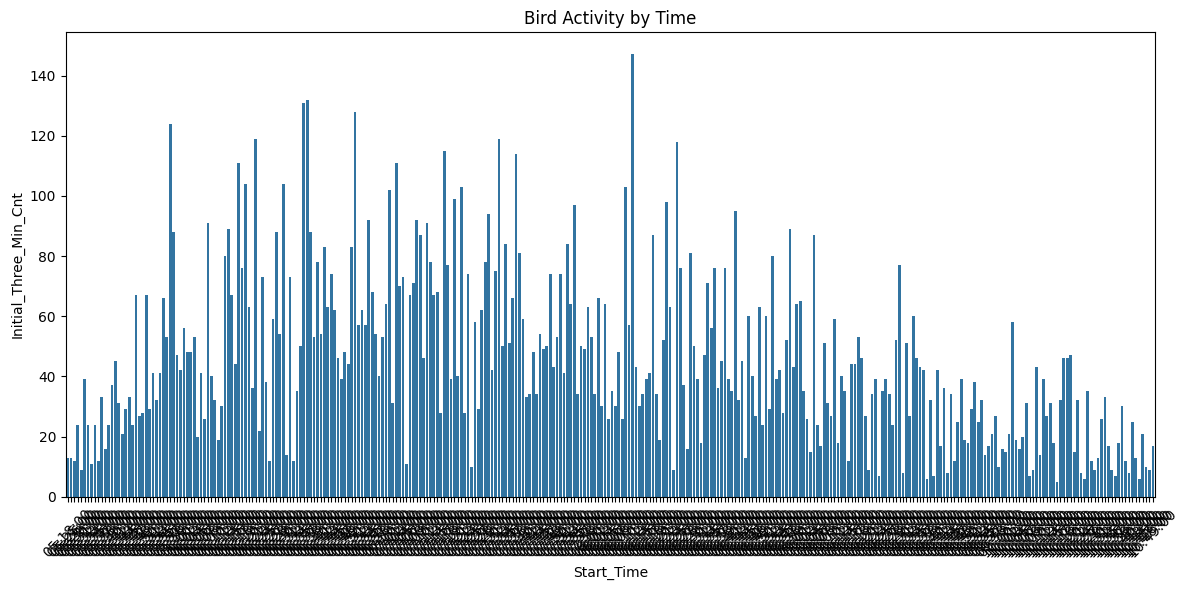

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(data=time_activity, x='Start_Time', y='Initial_Three_Min_Cnt')
plt.xticks(rotation=45)
plt.title('Bird Activity by Time')
plt.tight_layout()
plt.show()

In [29]:
df['Start_Hour'] = pd.to_datetime(df['Start_Time_mod'], format = '%H:%M:%S').dt.hour

In [30]:
df['Start_Hour']

0        6
1        6
2        6
3        6
4        6
        ..
17053    6
17054    6
17056    6
17060    6
17062    6
Name: Start_Hour, Length: 14625, dtype: int32

In [31]:
# For half hour bin (optional)

df['Start_Half_Hour'] = pd.to_datetime(df['Start_Time_mod'], format = '%H:%M:%S').dt.floor('30min').dt.time

In [32]:
hourly_activity = df.groupby(['Start_Hour','Location_Type'])['Initial_Three_Min_Cnt'].sum().reset_index()

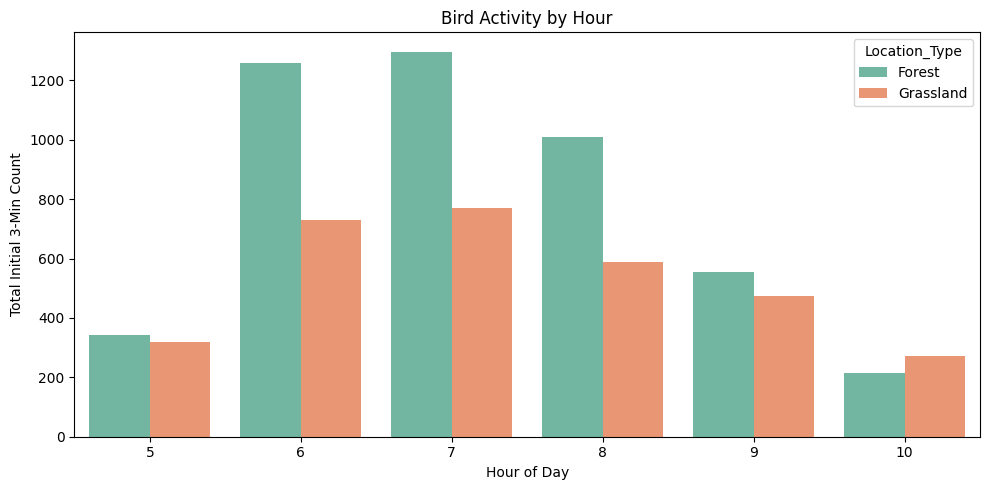

In [33]:
plt.figure(figsize=(10, 5))
sns.barplot(data=hourly_activity, x='Start_Hour', y='Initial_Three_Min_Cnt',hue ='Location_Type', palette='Set2')
plt.title("Bird Activity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Total Initial 3-Min Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
half_hour_activity = df.groupby(['Start_Half_Hour','Location_Type'])['Initial_Three_Min_Cnt'].sum().reset_index()


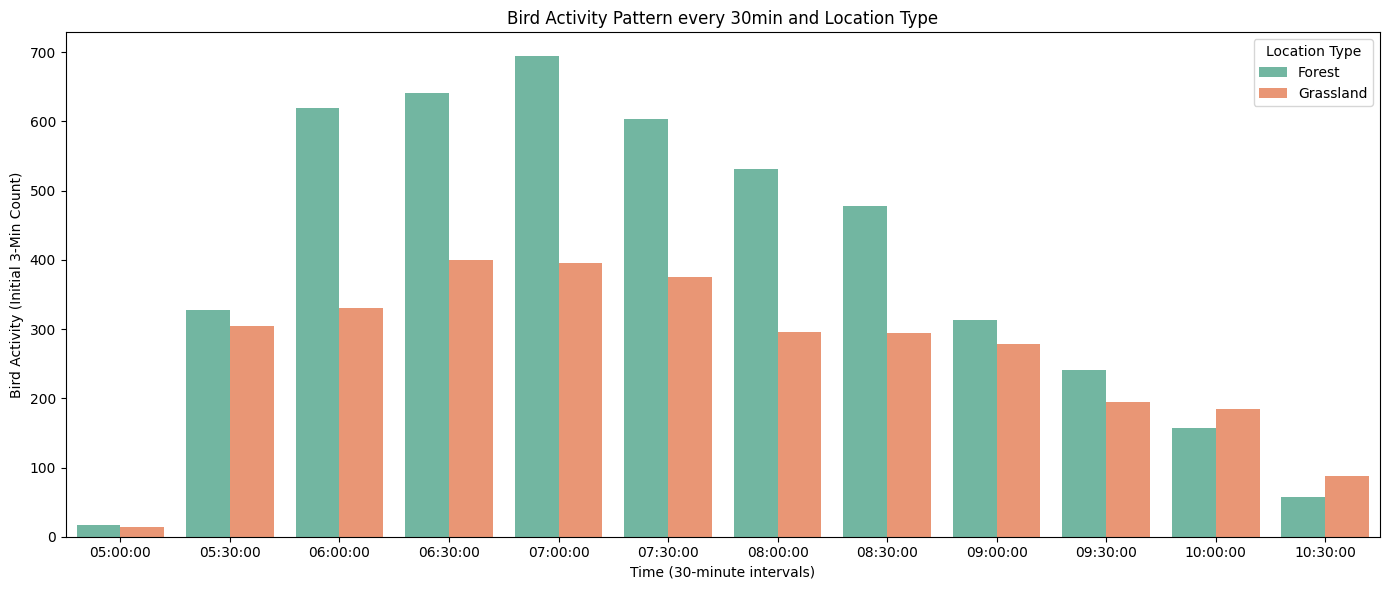

In [35]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data= half_hour_activity,
    x='Start_Half_Hour',
    y='Initial_Three_Min_Cnt',
    hue='Location_Type',
    palette='Set2')

plt.xticks(rotation=0)
plt.xlabel('Time (30-minute intervals)')
plt.ylabel('Bird Activity (Initial 3-Min Count)')
plt.title('Bird Activity Pattern every 30min and Location Type')
plt.legend(title='Location Type')
plt.tight_layout()
plt.show()

In [36]:
# Analysis by Season

df['Month'] = pd.to_datetime(df['Date'], format= "%Y-%m-%d" ).dt.month_name()


In [37]:
get_season = {
    "January": "Winter",
    "February": "Winter",
    "March": "Spring",
    "April": "Spring",
    "May": "Summer",
    "June": "Summer",
    "July": "Monsoon",
    "August": "Monsoon",
    "September": "Autumn",
    "October": "Autumn",
    "November": "Pre-Winter",
    "December": "Pre-Winter"
}

df['Season'] = df['Month'].map(get_season)

In [38]:
seasonal_activity = df.groupby(['Season','Location_Type'])['Initial_Three_Min_Cnt'].sum().reset_index()
seasonal_activity

,Season,Location_Type,Initial_Three_Min_Cnt
0,Monsoon,Forest,1219
1,Monsoon,Grassland,1036
2,Summer,Forest,3460
3,Summer,Grassland,2118


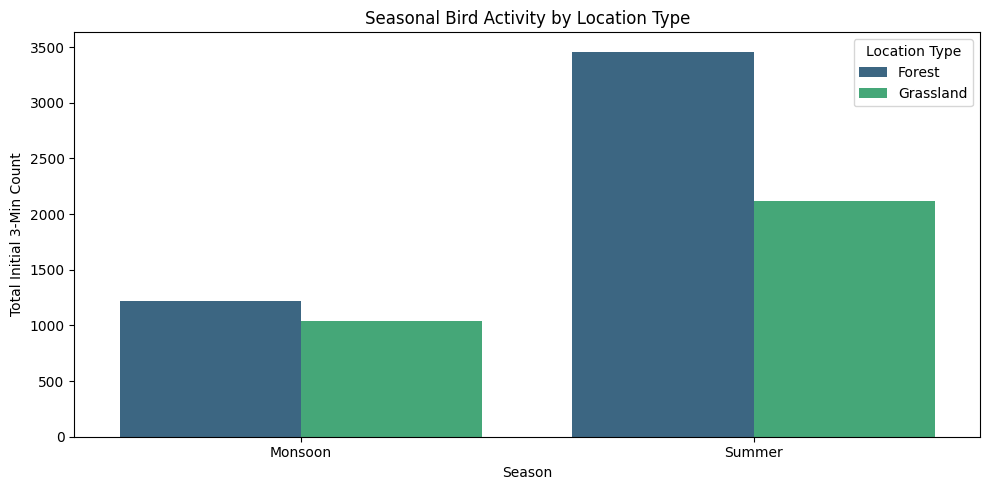

In [39]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=seasonal_activity,
    x='Season',
    y='Initial_Three_Min_Cnt',
    hue='Location_Type',
    palette='viridis'
)

plt.title("Seasonal Bird Activity by Location Type")
plt.xlabel("Season")
plt.ylabel("Total Initial 3-Min Count")
plt.legend(title="Location Type")
plt.tight_layout()
plt.show()

In [40]:
top_species = df.groupby(['Location_Type','Season','Common_Name'])['Initial_Three_Min_Cnt'].value_counts().nlargest(15).reset_index(name = 'Count')


In [41]:
top_species

,Location_Type,Season,Common_Name,Initial_Three_Min_Cnt,Count
0,Forest,Summer,Red-eyed Vireo,True,324
1,Forest,Summer,Carolina Wren,True,271
2,Forest,Summer,Northern Cardinal,True,252
3,Forest,Summer,Eastern Wood-Pewee,True,235
4,Forest,Summer,Northern Cardinal,False,227
5,Forest,Summer,Eastern Tufted Titmouse,True,212
6,Forest,Summer,Carolina Wren,False,207
7,Grassland,Summer,Field Sparrow,True,186
8,Grassland,Summer,Indigo Bunting,True,178
9,Forest,Summer,Red-bellied Woodpecker,True,177


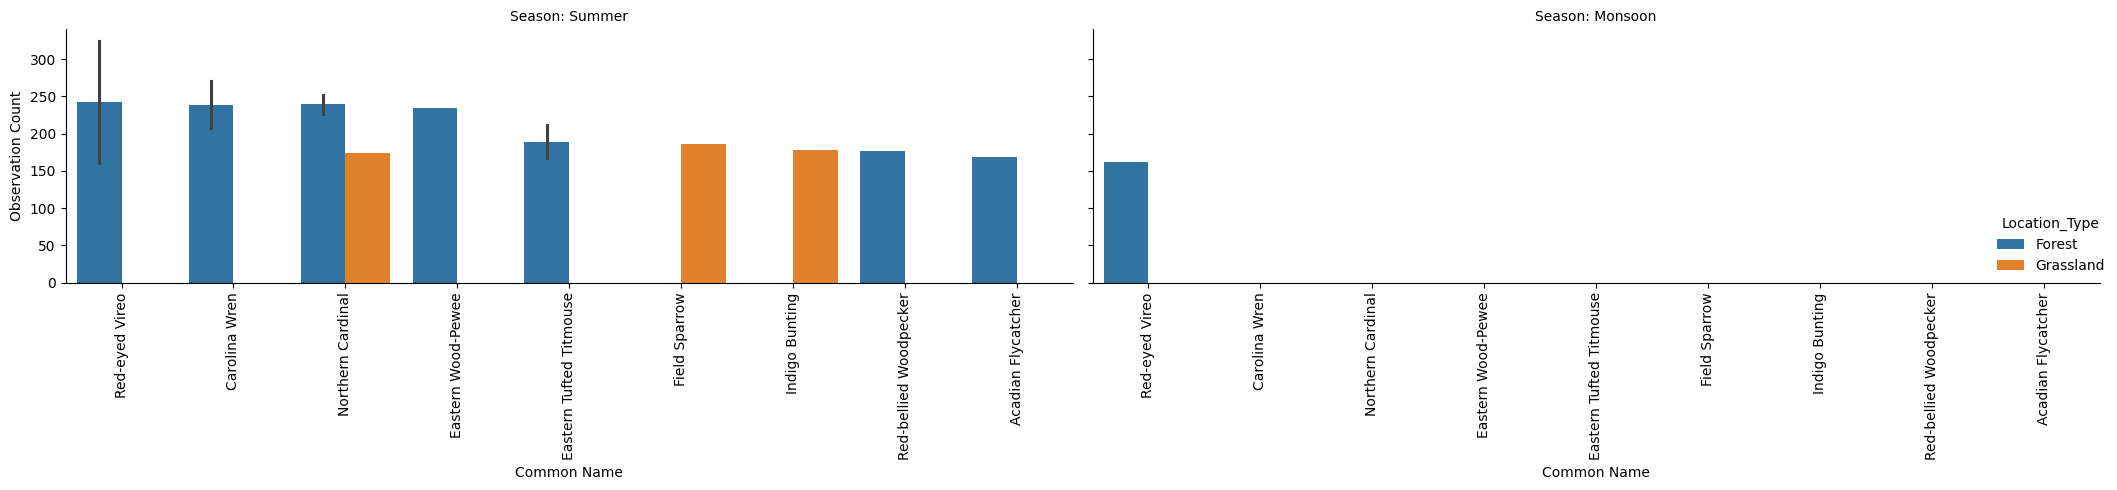

In [42]:
g = sns.catplot(
    data=top_species,
    x='Common_Name',
    y='Count',
    hue='Location_Type',
    col='Season',
    kind='bar',
    height=5,
    aspect=2
)

g.set_xticklabels(rotation=90)
g.set_titles("Season: {col_name}")
g.set_axis_labels("Common Name", "Observation Count")
plt.tight_layout()
plt.show()

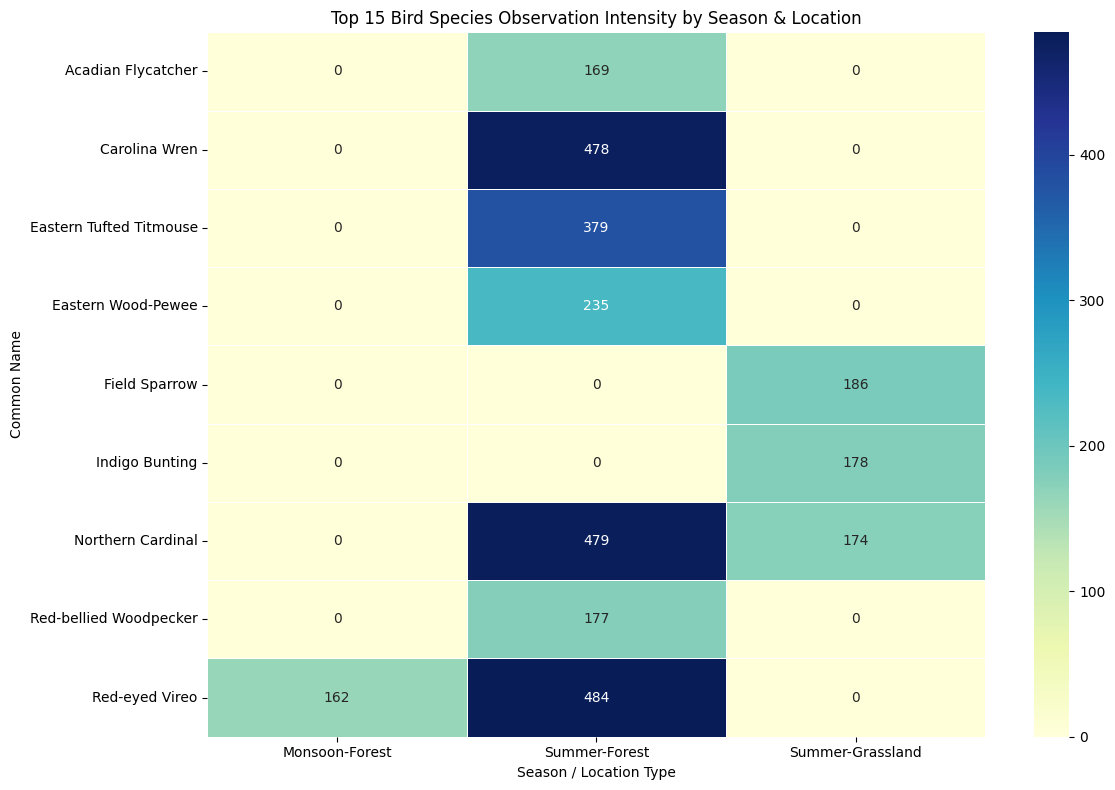

In [43]:
heatmap_data = top_species.pivot_table(
    index='Common_Name', 
    columns=['Season', 'Location_Type'], 
    values='Count', 
    aggfunc='sum',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)

plt.title('Top 15 Bird Species Observation Intensity by Season & Location')
plt.ylabel('Common Name')
plt.xlabel('Season / Location Type')
plt.tight_layout()
plt.show()

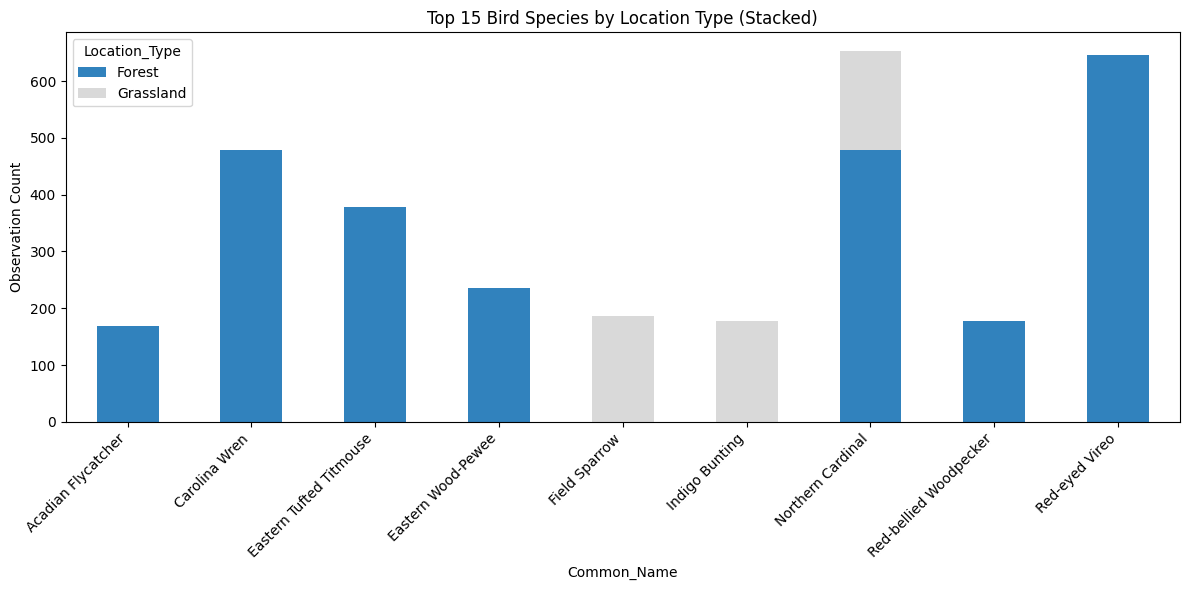

In [44]:
stack_data = top_species.pivot_table(
    index='Common_Name',
    columns='Location_Type',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

# Plot
stack_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20c')
plt.title('Top 15 Bird Species by Location Type (Stacked)')
plt.ylabel('Observation Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
pie_data = df.groupby(['Location_Type', 'Common_Name']).size().reset_index(name='Count')
pie_data

,Location_Type,Common_Name,Count
0,Forest,Acadian Flycatcher,436
1,Forest,American Crow,142
2,Forest,American Goldfinch,147
3,Forest,American Redstart,25
4,Forest,American Robin,294
...,...,...,...
209,Grassland,Wood Thrush,19
210,Grassland,Yellow Warbler,6
211,Grassland,Yellow-billed Cuckoo,43
212,Grassland,Yellow-breasted Chat,5


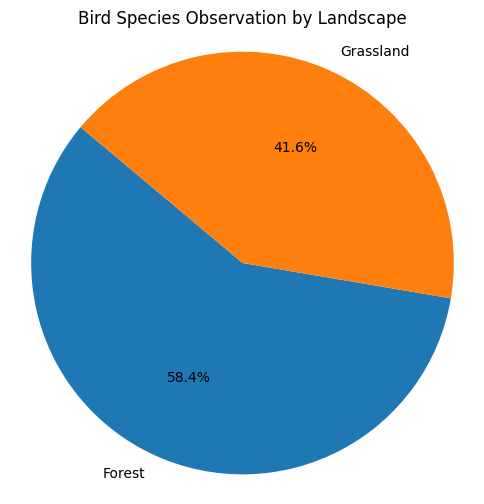

In [46]:
grouped = pie_data.groupby('Location_Type')['Count'].sum().reset_index()

plt.figure(figsize=(6, 6))
plt.pie(
    grouped['Count'],
    labels=grouped['Location_Type'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Bird Species Observation by Landscape')
plt.axis('equal')
plt.show()

In [47]:
species_counts = df.groupby(['Location_Type','Common_Name'])['Initial_Three_Min_Cnt'].count().reset_index()
species_counts = species_counts.rename(columns={'Initial_Three_Min_Cnt': 'Count'})

In [48]:
species_counts

,Location_Type,Common_Name,Count
0,Forest,Acadian Flycatcher,436
1,Forest,American Crow,142
2,Forest,American Goldfinch,147
3,Forest,American Redstart,25
4,Forest,American Robin,294
...,...,...,...
209,Grassland,Wood Thrush,19
210,Grassland,Yellow Warbler,6
211,Grassland,Yellow-billed Cuckoo,43
212,Grassland,Yellow-breasted Chat,5


In [49]:
species_counts = species_counts[species_counts['Count']>100].reset_index(drop=True)

In [50]:
fd = species_counts[species_counts['Location_Type'] == 'Forest']
gd = species_counts[species_counts['Location_Type'] == 'Grassland']

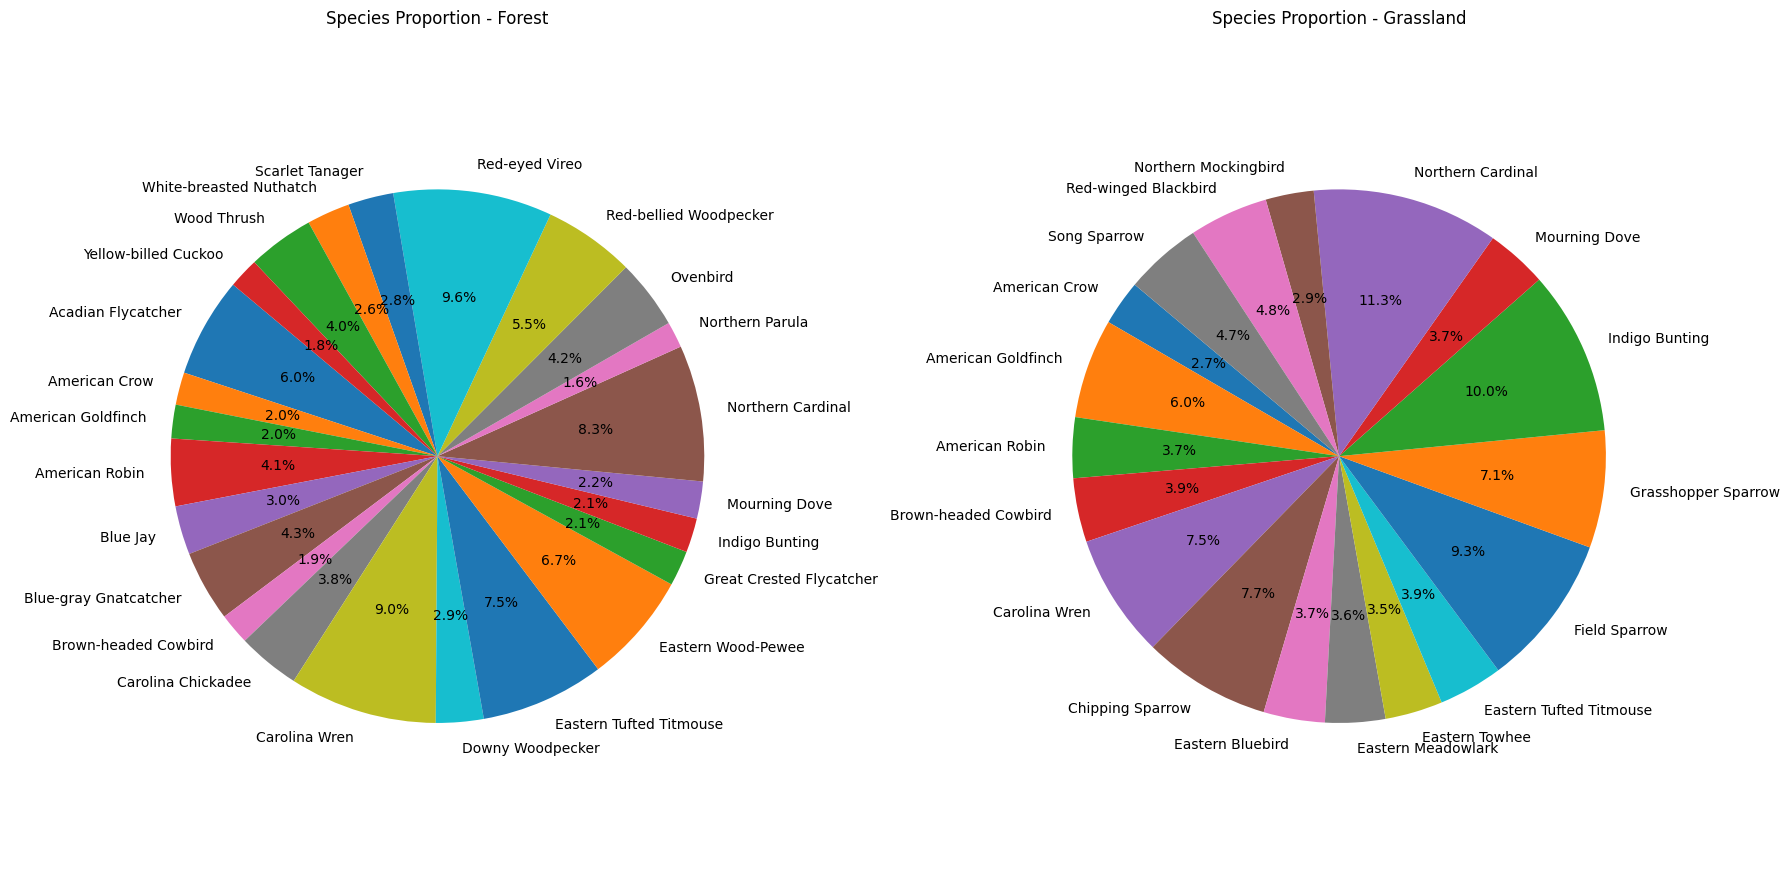

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Forest Data
axes[0].pie(fd['Count'], labels=fd['Common_Name'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Species Proportion - Forest')
axes[0].axis('equal')

# Grassland Data
axes[1].pie(gd['Count'], labels=gd['Common_Name'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Species Proportion - Grassland')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

In [52]:
'''
Relation between Environment and Bird Activity
column involved Temperature, Humidity,Sky,Wind, Disturbance
for Bird activity : Initial_Three_Min_Cnt

'''

df['Temperature_mod'] = df['Temperature'].round(2)

df['Temperature_mod'].value_counts()


Temperature_mod
22.0    373
23.2    264
23.6    214
21.6    214
22.6    205
       ... 
11.8      5
31.3      5
33.8      4
32.6      3
11.6      2
Name: count, Length: 210, dtype: int64

In [53]:
df['Humidity_mod'] = df['Humidity'].round(2)
df['Humidity_mod'].value_counts()

Humidity_mod
70.0    201
77.5    172
84.2    126
68.6    108
67.5    107
       ... 
91.3      3
42.8      3
66.8      2
40.1      2
66.2      2
Name: count, Length: 432, dtype: int64

In [54]:
env_df = df[df['Initial_Three_Min_Cnt']==True]

In [55]:
env_activity = env_df.groupby(['Location_Type','Temperature_mod','Humidity_mod','Initial_Three_Min_Cnt']).size().reset_index(name='Count')
env_activity

,Location_Type,Temperature_mod,Humidity_mod,Initial_Three_Min_Cnt,Count
0,Forest,11.0,90.8,True,5
1,Forest,11.2,81.5,True,2
2,Forest,13.8,83.4,True,4
3,Forest,13.8,91.5,True,3
4,Forest,13.9,75.2,True,5
...,...,...,...,...,...
1287,Grassland,35.1,47.6,True,3
1288,Grassland,35.5,43.5,True,3
1289,Grassland,35.6,36.8,True,5
1290,Grassland,36.2,41.8,True,5


In [56]:
env_activity['Temperature_mod'].value_counts()

Temperature_mod
22.0    25
23.2    24
23.6    20
21.6    18
21.4    18
        ..
30.1     1
28.3     1
30.4     1
11.4     1
37.3     1
Name: count, Length: 210, dtype: int64

In [57]:
env_activity['Temp_mod_bin'] = pd.cut(env_activity['Temperature_mod'], bins=6)

env_activity['Humidity_mod_bin'] = pd.cut(env_activity['Humidity_mod'], bins=6)

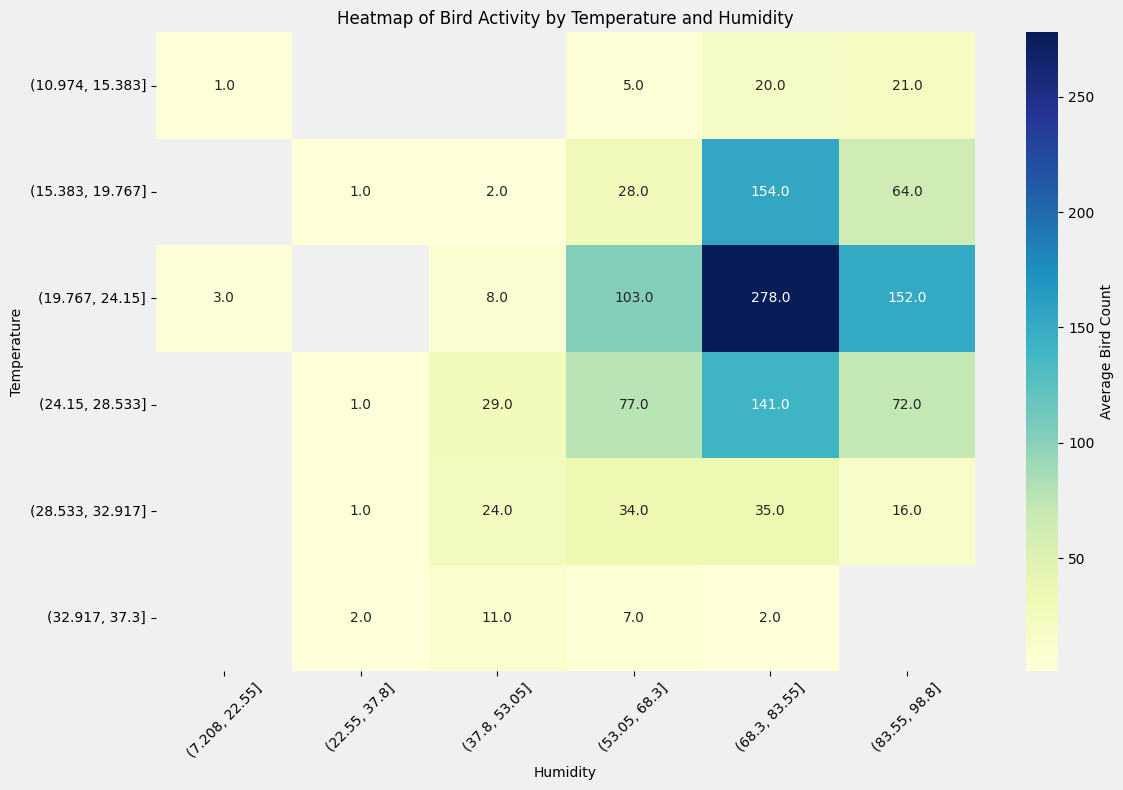

In [58]:
heatmap_data = env_activity.groupby(['Temp_mod_bin', 'Humidity_mod_bin'], observed=True)['Count'].size().unstack()

fig, ax = plt.subplots(figsize=(12, 8))

# Setting up the Back ground colour
fig.patch.set_facecolor('#f0f0f0')  # HTML Code from online
ax.set_facecolor('#f0f0f0')  # HTML Code from online

sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlGnBu', cbar_kws={'label': 'Average Bird Count'})

plt.title('Heatmap of Bird Activity by Temperature and Humidity')
plt.xlabel('Humidity')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()